In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import zipfile
import os
import shutil

import warnings
warnings.filterwarnings("ignore")

In [9]:

color_p= ["#1984c5", "#63bff0", "#a7d5ed", "#de6e56", "#e14b31", "#c23728"]


# Function definitions
shared_columns = ['idx','dimension', 'rot_type', 'angle', 'mirror', 'wm', 
                  'pair_id', 'obj_id', 'orientation1', 'orientation2', 'image_path_1', 'image_path_2',
                  'marker_id', 'correctAns', 'strategy_response', 'key_resp_strat_control.keys', 'key_resp_strat_control.rt',
                  'vivid_response', 'key_resp_vivid_slider_control.keys', 'key_resp_vivid_slider_control.rt', 'participant']

def get_ans_key(row):
    keys_possible_cols = ['key_resp.keys', 'key_resp_2.keys', 'key_resp_3.keys', 'key_resp_4.keys', 'key_resp_6.keys']
    rt_possible_cols = ['key_resp.rt', 'key_resp_2.rt', 'key_resp_3.rt', 'key_resp_4.rt', 'key_resp_6.rt']
    for key, rt in zip(keys_possible_cols, rt_possible_cols):
        if not pd.isna(row[key]) and row[key] != '':
            return row[key], row[rt]
    return np.nan, np.nan

def get_strategy_response(row):
    if (not pd.isna(row['key_resp_strat_control.keys'])) and (row['key_resp_strat_control.keys'] != 'None') and (row['key_resp_strat_control.keys'] != ''):
        try:    
            strat_resp_list = eval(row['key_resp_strat_control.keys'])
            if len(strat_resp_list) > 0:
                last_key = strat_resp_list[-1]
                if last_key == 'rshift':
                    return 4
                elif last_key == 'slash':
                    return 3
                elif last_key == 'period':
                    return 2
                elif last_key == 'comma':
                    return 1
        except:
            print(row['key_resp_strat_control.keys'])
    return np.nan

def get_vivid_response(row):
    if (not pd.isna(row['key_resp_vivid_slider_control.keys'])) and (row['key_resp_vivid_slider_control.keys'] != 'None') and (row['key_resp_vivid_slider_control.keys'] != ''):
        try:    
            vivid_resp_list = eval(row['key_resp_vivid_slider_control.keys'])
            if len(vivid_resp_list) > 0:
                last_key = vivid_resp_list[-1]
                if last_key == 'rshift':
                    return 4
                elif last_key == 'slash':
                    return 3
                elif last_key == 'period':
                    return 2
                elif last_key == 'comma':
                    return 1
        except:
            print(row['key_resp_vivid_slider_control.keys'])
    return np.nan

def get_block(row):
    if row['dimension'] == '2D':
        if row['wm'] == False:
            return '2D_single'
        elif row['wm'] == True:
            return '2D_wm'
        
    elif row['dimension'] == '3D':
        if row['rot_type'] == 'p':
            if row['wm'] == False:
                return '3Dp_single'
            elif row['wm'] == True:
                return '3Dp_wm'
        elif row['rot_type'] == 'd':
            if row['wm'] == False:
                return '3Dd_single'
            elif row['wm'] == True:
                return '3Dd_wm'

def get_corr(row):
    if row['ans_key'] is np.nan:
        return np.nan
    else:
        if row['correctAns'] == row['ans_key']:
            return 1
        else:
            return 0


def parse_excel(df):
    df_blocks = df[~df['dimension'].isna()]
    df_blocks.reset_index(drop=True, inplace=True)
    df_blocks['idx'] = df_blocks.index
    df_parsed = pd.DataFrame(columns=shared_columns)
    df_parsed['ans_key'] = np.nan
    df_parsed['rt'] = np.nan
    # iterate over the rows of the dataframe to get the ans keys, corr, rt by get_ans_key function
    for idx, row in df_blocks.iterrows():
        key, rt = get_ans_key(row)
        df_parsed.loc[idx, 'ans_key'] = key
        df_parsed.loc[idx, 'rt'] = rt
        for col in shared_columns:
            df_parsed.loc[idx, col] = row[col]
            
        # replace all 'None' values with np.nan
    df_parsed.replace('None', np.nan, inplace=True)
        
    df_parsed['strategy_response'] = df_parsed.apply(get_strategy_response, axis=1)
    df_parsed['vivid_response'] = df_parsed.apply(get_vivid_response, axis=1)

    # fill na values in 'rot_type', 'pair_id', 'orientation1', 'orientation2', 'image_path_2' with not applicable
    for col in ['rot_type', 'pair_id', 'orientation1', 'orientation2', 'image_path_2']:
        df_parsed[col].fillna('na', inplace=True)
        
    df_parsed['block'] = df_parsed.apply(get_block, axis=1)
    df_parsed['corr'] = df_parsed.apply(get_corr, axis=1)
    return df_parsed


# make a new folder 'temp' to store the unzipped files and empty it if it already exists
import os
df_parsed_all = pd.DataFrame()
for file in os.listdir('temp'):
    if file.endswith('.csv'):
        df = pd.read_csv('temp/' + file)
        df_parsed = parse_excel(df)
        if len(df) > 0:
            df_parsed_all = pd.concat([df_parsed_all, df_parsed], axis=0)
        else:
            df__parsed_all = df_parsed

df_parsed_all.head()

df_parsed_all['participant'] = df_parsed_all['participant'].astype(str)

In [10]:
df_parsed_all.head()

,idx,dimension,rot_type,angle,mirror,wm,pair_id,obj_id,orientation1,orientation2,...,key_resp_strat_control.keys,key_resp_strat_control.rt,vivid_response,key_resp_vivid_slider_control.keys,key_resp_vivid_slider_control.rt,participant,ans_key,rt,block,corr
0,0,2D,na,60.0,False,False,na,sm2,300.0,0,...,['comma'],[1.3870992999291047],1.0,['comma'],[0.7388600000413135],3,period,2.413245,2D_single,0.0
1,1,2D,na,120.0,False,False,na,obj5,80.0,200,...,['period'],[1.8099804999073967],4.0,['rshift'],[1.0856915999902412],3,period,2.019634,2D_single,0.0
2,2,2D,na,180.0,True,False,na,obj9,80.0,260,...,['slash'],[1.884114700020291],4.0,['rshift'],[0.6996095000067726],3,period,2.315414,2D_single,1.0
3,3,2D,na,0.0,False,False,na,obj1,160.0,na,...,['comma'],[1.1295652999542654],4.0,['rshift'],[0.37282619997859],3,comma,1.243433,2D_single,1.0
4,4,2D,na,120.0,True,False,na,sm1,180.0,300,...,['period'],[1.8776962000411004],3.0,['slash'],[0.9892523000016809],3,period,3.274782,2D_single,1.0


<AxesSubplot: xlabel='block', ylabel='corr'>

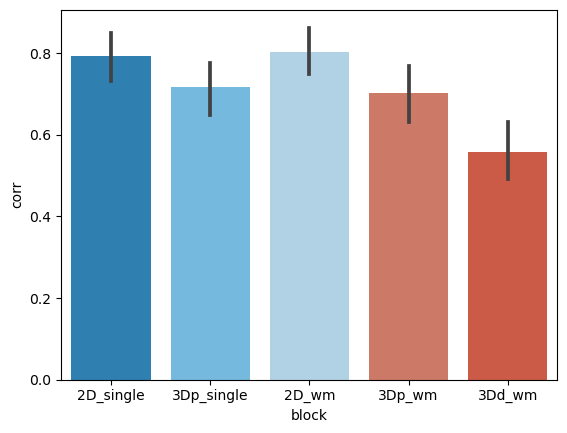

In [11]:
sns.barplot(x='block', y='corr', data=df_parsed_all, palette=color_p)